In [43]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt

# Data Cleaning 

In [44]:
cols = ['sentiment','id','date','query_string','user','text']

In [45]:
df = pd.read_csv("../data/tweets/training.1600000.processed.noemoticon.csv",header=None, names=cols,encoding = "ISO-8859-1")

In [46]:
df.head()

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
sentiment       1600000 non-null int64
id              1600000 non-null int64
date            1600000 non-null object
query_string    1600000 non-null object
user            1600000 non-null object
text            1600000 non-null object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [48]:
df.sentiment.value_counts()

4    800000
0    800000
Name: sentiment, dtype: int64

In [49]:
df.query_string.value_counts()

NO_QUERY    1600000
Name: query_string, dtype: int64

In [50]:
df.drop(['id','date','query_string','user'],axis=1,inplace=True)

In [51]:
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [52]:
df[df.sentiment == 0].head(10)

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


In [53]:
df[df.sentiment == 4].head(10)

,sentiment,text
800000,4,I LOVE @Health4UandPets u guys r the best!!
800001,4,im meeting up with one of my besties tonight! ...
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,Being sick can be really cheap when it hurts t...
800004,4,@LovesBrooklyn2 he has that effect on everyone
800005,4,@ProductOfFear You can tell him that I just bu...
800006,4,@r_keith_hill Thans for your response. Ihad al...
800007,4,"@KeepinUpWKris I am so jealous, hope you had a..."
800008,4,"@tommcfly ah, congrats mr fletcher for finally..."
800009,4,@e4VoIP I RESPONDED Stupid cat is helping me ...


In [54]:
df[df.sentiment == 0].index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            799990, 799991, 799992, 799993, 799994, 799995, 799996, 799997,
            799998, 799999],
           dtype='int64', length=800000)

In [55]:
df[df.sentiment == 4].index

Int64Index([ 800000,  800001,  800002,  800003,  800004,  800005,  800006,
             800007,  800008,  800009,
            ...
            1599990, 1599991, 1599992, 1599993, 1599994, 1599995, 1599996,
            1599997, 1599998, 1599999],
           dtype='int64', length=800000)

In [56]:
df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})
df.sentiment.value_counts()

1    800000
0    800000
Name: sentiment, dtype: int64

## Data Preparation

In [57]:
df['pre_clean_len'] = [len(t) for t in df.text]

In [58]:
from pprint import pprint
data_dict = {
    'sentiment':{
        'type':df.sentiment.dtype,
        'description':'sentiment class - 0:negative, 1:positive'
    },
    'text':{
        'type':df.text.dtype,
        'description':'tweet text'
    },
    'pre_clean_len':{
        'type':df.pre_clean_len.dtype,
        'description':'Length of the tweet before cleaning'
    },
    'dataset_shape':df.shape
}

pprint(data_dict)

{'dataset_shape': (1600000, 3),
 'pre_clean_len': {'description': 'Length of the tweet before cleaning',
                   'type': dtype('int64')},
 'sentiment': {'description': 'sentiment class - 0:negative, 1:positive',
               'type': dtype('int64')},
 'text': {'description': 'tweet text', 'type': dtype('O')}}


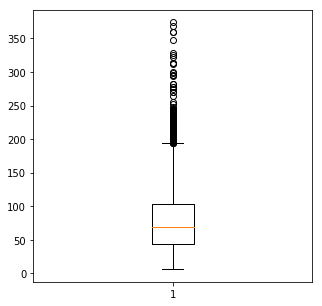

In [59]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.pre_clean_len)
plt.show()

In [60]:
df[df.pre_clean_len > 140].head(10)

,sentiment,text,pre_clean_len
213,0,Awwh babs... you look so sad underneith that s...,142
226,0,Tuesdayï¿½ll start with reflection ï¿½n then a...,141
279,0,Whinging. My client&amp;boss don't understand ...,145
343,0,@TheLeagueSF Not Fun &amp; Furious? The new ma...,145
400,0,#3 woke up and was having an accident - &quot;...,144
464,0,"My bathtub drain is fired: it haz 1 job 2 do, ...",146
492,0,"pears &amp; Brie, bottle of Cabernet, and &quo...",150
747,0,Have an invite for &quot;Healthy Dining&quot; ...,141
957,0,Damnit I was really digging this season of Rea...,141
1064,0,Why do I keep looking...I know that what I rea...,141


In [61]:
df.text[279]

"Whinging. My client&amp;boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&amp;reviewed correctly. "

In [62]:
from bs4 import BeautifulSoup
example1 = BeautifulSoup(df.text[279], 'lxml')
print(example1.get_text())

Whinging. My client&boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&reviewed correctly. 


In [63]:
df.text[343]

'@TheLeagueSF Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

In [64]:
import re
re.sub(r'@[A-Za-z0-9]+','',df.text[343])

' Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

In [65]:
df.text[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [66]:
re.sub('https?://[A-Za-z0-9./]+','',df.text[0])

"@switchfoot  - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [67]:
df.text[226]

'Tuesdayï¿½ll start with reflection ï¿½n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

In [68]:
testing = df.text[226]
testing

'Tuesdayï¿½ll start with reflection ï¿½n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

In [69]:
testing.replace('ï¿½','?')

'Tuesday?ll start with reflection ?n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

In [70]:
df.text[175]

"@machineplay I'm so sorry you're having to go through this. Again.  #therapyfail"

In [71]:
re.sub("[^a-zA-Z]", " ", df.text[175])

' machineplay I m so sorry you re having to go through this  Again    therapyfail'

## Data Cleaning Function

In [72]:
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

In [73]:
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

In [74]:
testing = df.text[:100]

In [75]:
test_result = []
for t in testing:
    test_result.append(tweet_cleaner(t))

In [76]:
test_result

['awww that s a bummer you shoulda got david carr of third day to do it d',
 'is upset that he can t update his facebook by texting it and might cry as a result school today also blah',
 'i dived many times for the ball managed to save the rest go out of bounds',
 'my whole body feels itchy and like its on fire',
 'no it s not behaving at all i m mad why am i here because i can t see you all over there',
 'not the whole crew',
 'need a hug',
 'hey long time no see yes rains a bit only a bit lol i m fine thanks how s you',
 'k nope they didn t have it',
 'que me muera',
 'spring break in plain city it s snowing',
 'i just re pierced my ears',
 'i couldn t bear to watch it and i thought the ua loss was embarrassing',
 'it it counts idk why i did either you never talk to me anymore',
 'i would ve been the first but i didn t have a gun not really though zac snyder s just a doucheclown',
 'i wish i got to watch it with you i miss you and how was the premiere',
 'hollis death scene will hurt

In [77]:
nums = [0,400000,800000,1200000,1600000]

In [78]:
%%time
print("Cleaning and parsing the tweets...\n")
clean_tweet_texts = []
for i in range(nums[0],nums[1]):
    if( (i+1)%10000 == 0 ):
        print("Tweets %d of %d has been processed" % ( i+1, nums[1] )                                                                    )
    clean_tweet_texts.append(tweet_cleaner(df['text'][i]))

Cleaning and parsing the tweets...

Tweets 10000 of 400000 has been processed
Tweets 20000 of 400000 has been processed
Tweets 30000 of 400000 has been processed
Tweets 40000 of 400000 has been processed
Tweets 50000 of 400000 has been processed
Tweets 60000 of 400000 has been processed
Tweets 70000 of 400000 has been processed
Tweets 80000 of 400000 has been processed
Tweets 90000 of 400000 has been processed
Tweets 100000 of 400000 has been processed
Tweets 110000 of 400000 has been processed
Tweets 120000 of 400000 has been processed
Tweets 130000 of 400000 has been processed
Tweets 140000 of 400000 has been processed
Tweets 150000 of 400000 has been processed
Tweets 160000 of 400000 has been processed
Tweets 170000 of 400000 has been processed
Tweets 180000 of 400000 has been processed
Tweets 190000 of 400000 has been processed
Tweets 200000 of 400000 has been processed
Tweets 210000 of 400000 has been processed
Tweets 220000 of 400000 has been processed
Tweets 230000 of 400000 has

In [79]:
len(clean_tweet_texts)

400000

In [80]:
%%time
print("Cleaning and parsing the tweets...\n")
for i in range(nums[1],nums[2]):
    if( (i+1)%10000 == 0 ):
        print("Tweets %d of %d has been processed" % ( i+1, nums[2] )) 
    clean_tweet_texts.append(tweet_cleaner(df['text'][i]))

Cleaning and parsing the tweets...

Tweets 410000 of 800000 has been processed
Tweets 420000 of 800000 has been processed
Tweets 430000 of 800000 has been processed
Tweets 440000 of 800000 has been processed
Tweets 450000 of 800000 has been processed
Tweets 460000 of 800000 has been processed
Tweets 470000 of 800000 has been processed
Tweets 480000 of 800000 has been processed
Tweets 490000 of 800000 has been processed
Tweets 500000 of 800000 has been processed
Tweets 510000 of 800000 has been processed
Tweets 520000 of 800000 has been processed
Tweets 530000 of 800000 has been processed
Tweets 540000 of 800000 has been processed
Tweets 550000 of 800000 has been processed
Tweets 560000 of 800000 has been processed
Tweets 570000 of 800000 has been processed
Tweets 580000 of 800000 has been processed
Tweets 590000 of 800000 has been processed
Tweets 600000 of 800000 has been processed
Tweets 610000 of 800000 has been processed
Tweets 620000 of 800000 has been processed
Tweets 630000 of 8

In [81]:
len(clean_tweet_texts)

800000

In [82]:
%%time
print("Cleaning and parsing the tweets...\n")
for i in range(nums[2],nums[3]):
    if( (i+1)%10000 == 0 ):
        print("Tweets %d of %d has been processed" % ( i+1, nums[3] ))
    clean_tweet_texts.append(tweet_cleaner(df['text'][i]))

Cleaning and parsing the tweets...

Tweets 810000 of 1200000 has been processed
Tweets 820000 of 1200000 has been processed
Tweets 830000 of 1200000 has been processed
Tweets 840000 of 1200000 has been processed
Tweets 850000 of 1200000 has been processed
Tweets 860000 of 1200000 has been processed
Tweets 870000 of 1200000 has been processed
Tweets 880000 of 1200000 has been processed
Tweets 890000 of 1200000 has been processed
Tweets 900000 of 1200000 has been processed
Tweets 910000 of 1200000 has been processed
Tweets 920000 of 1200000 has been processed
Tweets 930000 of 1200000 has been processed
Tweets 940000 of 1200000 has been processed
Tweets 950000 of 1200000 has been processed
Tweets 960000 of 1200000 has been processed
Tweets 970000 of 1200000 has been processed
Tweets 980000 of 1200000 has been processed
Tweets 990000 of 1200000 has been processed
Tweets 1000000 of 1200000 has been processed
Tweets 1010000 of 1200000 has been processed
Tweets 1020000 of 1200000 has been pro

In [83]:
len(clean_tweet_texts)

1200000

In [84]:
%%time
print("Cleaning and parsing the tweets...\n")
for i in range(nums[3],nums[4]):
    if( (i+1)%10000 == 0 ):
        print("Tweets %d of %d has been processed" % ( i+1, nums[4] ))
    clean_tweet_texts.append(tweet_cleaner(df['text'][i]))

Cleaning and parsing the tweets...

Tweets 1210000 of 1600000 has been processed
Tweets 1220000 of 1600000 has been processed
Tweets 1230000 of 1600000 has been processed
Tweets 1240000 of 1600000 has been processed
Tweets 1250000 of 1600000 has been processed
Tweets 1260000 of 1600000 has been processed
Tweets 1270000 of 1600000 has been processed
Tweets 1280000 of 1600000 has been processed
Tweets 1290000 of 1600000 has been processed
Tweets 1300000 of 1600000 has been processed
Tweets 1310000 of 1600000 has been processed
Tweets 1320000 of 1600000 has been processed
Tweets 1330000 of 1600000 has been processed
Tweets 1340000 of 1600000 has been processed
Tweets 1350000 of 1600000 has been processed
Tweets 1360000 of 1600000 has been processed
Tweets 1370000 of 1600000 has been processed
Tweets 1380000 of 1600000 has been processed
Tweets 1390000 of 1600000 has been processed
Tweets 1400000 of 1600000 has been processed
Tweets 1410000 of 1600000 has been processed
Tweets 1420000 of 1

In [85]:
len(clean_tweet_texts)

1600000

In [86]:
clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])
clean_df['target'] = df.sentiment
clean_df.head()

,text,target
0,awww that s a bummer you shoulda got david car...,0
1,is upset that he can t update his facebook by ...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i h...,0


In [87]:
clean_df.to_csv('../data/clean_tweet.csv',encoding='utf-8')

# Model

In [88]:
csv = '../data/clean_tweet.csv'
df = pd.read_csv(csv,index_col=0)
df.head()

/home/ghost/.local/lib/python3.5/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,text,target
0,awww that s a bummer you shoulda got david car...,0
1,is upset that he can t update his facebook by ...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i h...,0


In [89]:
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596753 entries, 0 to 1596752
Data columns (total 2 columns):
text      1596753 non-null object
target    1596753 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [90]:
x = df.text
y = df.target

In [91]:
from sklearn.model_selection import train_test_split

SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [63]:
fmt1_ = "Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive"
print(fmt1_.format(len(x_train),
      (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
      (len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
      
fmt2_ = "Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive"
print(fmt2_.format(len(x_validation),
      (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
      (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))

fmt3_ = "Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive"
print(fmt3_.format(len(x_test),
      (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
      (len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Train set has total 1564817 entries with 50.00% negative, 50.00% positive
Validation set has total 15968 entries with 50.26% negative, 49.74% positive
Test set has total 15968 entries with 50.18% negative, 49.82% positive


In [64]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils

In [65]:
def labelize_tweets_ug(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result

In [66]:
all_x = pd.concat([x_train,x_validation,x_test])
all_x_w2v = labelize_tweets_ug(all_x, 'all')

In [67]:
cores = multiprocessing.cpu_count()
model_ug_cbow = Word2Vec(sg=0, size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_cbow.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|██████████| 1596753/1596753 [00:00<00:00, 2835877.35it/s]


In [68]:
%%time
for epoch in range(30):
    model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_cbow.alpha -= 0.002
    model_ug_cbow.min_alpha = model_ug_cbow.alpha

100%|██████████| 1596753/1596753 [00:00<00:00, 2917609.47it/s]


CPU times: user 18min 21s, sys: 4.26 s, total: 18min 25s
Wall time: 6min 30s


In [69]:
model_ug_sg = Word2Vec(sg=1, size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)])

100%|██████████| 1596753/1596753 [00:00<00:00, 2857163.12it/s]


In [70]:
%%time
for epoch in range(30):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_sg.alpha -= 0.002
    model_ug_sg.min_alpha = model_ug_sg.alpha

100%|██████████| 1596753/1596753 [00:00<00:00, 2532277.97it/s]


CPU times: user 36min 3s, sys: 5.46 s, total: 36min 9s
Wall time: 7min 52s


In [72]:
model_ug_cbow.save('../data/vocab/w2v_model_ug_cbow.word2vec')
model_ug_sg.save('../data/vocab/w2v_model_ug_sg.word2vec')

# Convert Word to a Number

In [3]:
from gensim.models import KeyedVectors
model_ug_cbow = KeyedVectors.load('../data/vocab/w2v_model_ug_cbow.word2vec')
model_ug_sg = KeyedVectors.load('../data/vocab/w2v_model_ug_sg.word2vec')

In [4]:
len(model_ug_cbow.wv.vocab.keys())

109573

In [8]:
embeddings_index = {}
for w in model_ug_cbow.wv.vocab.keys():
    embeddings_index[w] = np.append(model_ug_cbow.wv[w],model_ug_sg.wv[w])
print('Found %s word vectors.' % len(embeddings_index))

Found 109573 word vectors.


In [92]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

In [93]:
len(tokenizer.word_index)

270406

In [94]:
for x in x_train[:5]:
    print(x)

i love it walking home from my night out people in the street were drunkenly talking about how well we did in eurovision i love europe
and thats gross
just had surgery i m tired but my lip hurts too much to sleep this blows
i wish there was more fun in my big bag of fun i bored hours to go
and i bet you were one of these chicks


In [95]:
sequences[:5]

[[1,
  45,
  6,
  983,
  78,
  56,
  5,
  70,
  35,
  144,
  10,
  3,
  1216,
  161,
  31630,
  492,
  61,
  69,
  74,
  48,
  122,
  10,
  3853,
  1,
  45,
  1916],
 [7, 295, 1830],
 [22, 64, 1621, 1, 20, 173, 21, 5, 2573, 361, 43, 88, 2, 113, 28, 3204],
 [1, 111, 67, 27, 85, 109, 10, 5, 243, 1151, 14, 109, 1, 259, 212, 2, 40],
 [7, 1, 782, 8, 161, 57, 14, 395, 4407]]

In [96]:
length = []
for x in x_train:
    length.append(len(x.split()))

In [97]:
max(length)

52

In [98]:
x_train_seq = pad_sequences(sequences, maxlen=45)
print('Shape of data tensor:', x_train_seq.shape)

Shape of data tensor: (1564817, 45)


In [99]:
x_train_seq[:5]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     1,    45,     6,   983,    78,    56,     5,    70,
           35,   144,    10,     3,  1216,   161, 31630,   492,    61,
           69,    74,    48,   122,    10,  3853,     1,    45,  1916],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     7,   295,  1830],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,    22,    64,  1621,     1,    20,   173,    21,
    

In [100]:
sequences_val = tokenizer.texts_to_sequences(x_validation)
x_val_seq = pad_sequences(sequences_val, maxlen=45)

In [101]:
num_words = 100000
embedding_matrix = np.zeros((num_words, 200))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [102]:
np.array_equal(embedding_matrix[6] ,embeddings_index.get('you'))

False

In [103]:
seed = 7

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

# Model: Convolutional Neural Network

In [106]:
from keras.layers import Input, Dense, concatenate, Activation
from keras.models import Model
from keras.layers import Conv1D, GlobalMaxPooling1D

tweet_input = Input(shape=(45,), dtype='int32')

tweet_encoder = Embedding(100000, 200, weights=[embedding_matrix], input_length=45, trainable=True)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 45)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 45, 200)      20000000    input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 44, 100)      40100       embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 43, 100)      60100       embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_3 (

In [ ]:
from keras.callbacks import ModelCheckpoint

filepath="CNN_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

model.fit(x_train_seq, y_train, batch_size=32, epochs=5,
                     validation_data=(x_val_seq, y_validation), callbacks = [checkpoint])

In [ ]:
from keras.models import load_model
loaded_CNN_model = load_model('CNN_best_weights.02-0.8333.hdf5')
loaded_CNN_model.evaluate(x=x_val_seq, y=y_validation)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer(max_features=100000,ngram_range=(1, 3))
tvec.fit(x_train)

In [ ]:
x_train_tfidf = tvec.transform(x_train)
x_test_tfidf = tvec.transform(x_test)

In [ ]:
lr_with_tfidf = LogisticRegression()
lr_with_tfidf.fit(x_train_tfidf,y_train)

In [ ]:
lr_with_tfidf.score(x_test_tfidf,y_test)

In [ ]:
yhat_lr = lr_with_tfidf.predict_proba(x_test_tfidf)

In [ ]:
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=45)

In [ ]:
loaded_CNN_model.evaluate(x=x_test_seq, y=y_test)

In [ ]:
yhat_cnn = loaded_CNN_model.predict(x_test_seq)

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test, yhat_lr[:,1])
roc_auc = auc(fpr, tpr)
fpr_cnn, tpr_cnn, threshold = roc_curve(y_test, yhat_cnn)
roc_auc_nn = auc(fpr_cnn, tpr_cnn)
plt.figure(figsize=(8,7))
plt.plot(fpr, tpr, label='tfidf-logit (area = %0.3f)' % roc_auc, linewidth=2)
plt.plot(fpr_cnn, tpr_cnn, label='w2v-CNN (area = %0.3f)' % roc_auc_nn, linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is positive', fontsize=18)
plt.legend(loc="lower right")
plt.show()